# Proyecto I: Filter Me!!

El objetivo de este proyecto es desarrollar una serie de filtros donde se utilice conceptos de mejora de contraste, y uso de mascaras de filtrado espacial para alterar una imagen obtenida a travez de una camara de video, en tiempo real. La imagen adquirida y procesada debe estar en escala de color. Para este proyecto se pide que los estudiantes implementen las funciones de:

1. Ecualización de histograma.
2. Difuminado de imagenes.
3. Detección de bordes.
4. Mejora de la Nitidez (sharpness).

El entregable debe cumplir las siguientes caracteristicas:

1. Facil de usar.
2. Se debe poder seleccionar que tipo de proceso se realiza sobre la imagen (ecualizacion de histograma, detecci'on bordes, etc)
3. Se debe mostrar la salida en tiempo real, es decir se debe mostrar el video actual como se procesa.
4. Tambien debe mostrar ejemplos de imagenes procesadas (Offline) con cada uno de los algoritmos implementados.

Al entregar el proyecto deben presentar los programas, ya sea en un ejecutable o en un notebook de jupiter. y deben entregar las respuestas a las psiguientes preguntas:

1. ¿Cual de los programas implementados corre de forma más lenta y cual de forma más rápida? ¿Porqué?
2. ¿Cómo puedo mejorar la velocidad de los algoritmos de procesamiento? ¿Qué consecuencias tiene esto?
3. Si los programas tienen problemas para realizar las operaciones dentro del tiempo considerado tiempo real, ¿cómo se puede mejorar esto?
4. ¿Fueron los resultados obtenidos satisfactorios? Elabore su respuesta.


Para realizar los programas pueden usar las librerias opencv, esta soporta el manejo de video. Por otro lado pueden usar [gradio](https://gradio.app) para desarrollar una interfaz de forma facil.

Para el desarrollo del proyecto se debne hacer en grupos de dos personas (solo se admite un grupo de 3). Tenga en cuenta que con quien desarrolla este proyecto, no puede desarrollar proyecto en un futuro. **La fecha limite de entrega del proyecto es el Lunes 28 de Febrero del 2022.**

Mucha suerte!!

In [24]:
import numpy as np
# import numba as nb 
import cv2
from scipy import signal
from matplotlib import pyplot as plt
from scipy.ndimage import convolve1d

### 1) Ecualización de imagen

In [27]:
def equalize_hsv_channel(img, channel=2):
    n, m, _ = np.shape(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    sat = img[:,:,channel]
    unique, counts = np.unique(sat, return_counts=True) 
    mapping = np.zeros(256)
    
    mapping[unique] = counts
    mapping = 255/(m*n)*np.cumsum(mapping)
    img[:,:,channel] = mapping[sat]
    return cv2.cvtColor(img, cv2.COLOR_HSV2RGB)


CPU times: user 77.1 ms, sys: 19.3 ms, total: 96.4 ms
Wall time: 88 ms


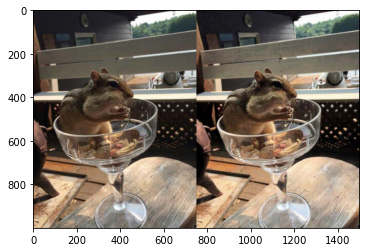

In [3]:
%%time
img = cv2.cvtColor(cv2.imread("../imgs/img1.jpg") , cv2.COLOR_BGR2RGB)
plt.imshow(np.column_stack([img,equalize_hsv_channel(img, 2)]))

### 3) Detección de bordes

***Función de convolución 2D:***

In [4]:
def convolve2D(image: np.ndarray, kernel: np.ndarray):
    
    #wraper para la función de convolución 2d
    
    return signal.convolve2d(image, kernel, mode='same', boundary='fill')

***Creacion de los kernel de convolución:***

In [5]:
def make_sobelx_kernel():
    return np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])

In [6]:
def make_sobely_kernel():
    return np.array([[1, 2, 1],[0, 0, 0],[-1, -2, -1]])

In [7]:
def laplacian_kernel():
    return np.array([[0,1,0],[1,-4,1],[0,1,0]])

***Detección de los bordes con los distintos kernel (filtros sobel y laplaciano):***

In [29]:
def sobel(img: np.ndarray, normalize=True):
    
    #convierte la imagen a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #hace el kernel sobel x
    kx = make_sobelx_kernel()

    #hace el kernel sobel y
    ky = make_sobely_kernel()
    
    #aplica el filtro sobel en x e y 
    convolved_img_x = convolve2D(gray, kx)
    convolved_img_y = convolve2D(gray, ky)

    #suma las imagenes filtradas con sobel
    convolved_img = (convolved_img_x + convolved_img_y)
    
    if normalize:
        convolved_img = ((convolved_img - np.mean(convolved_img)) / (np.var(convolved_img)))
        return (255*convolved_img).astype('uint8')

    else:
        return convolved_img.astype('uint8')   

In [30]:
def laplace(img, normalize=True):
    #convierte la imagen a escala de grises
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #kernel de laplace
    kl = laplacian_kernel()
    
    #aplica el filtro del kernel de laplace
    convolved_img = convolve2D(gray, kl)
    
    if normalize:
        convolved_img = (convolved_img -np.mean(convolved_img))/(np.var(convolved_img))
        return (255*convolved_img).astype('uint8')

    else:
        return convolved_img.astype('uint8')    

CPU times: total: 78.1 ms
Wall time: 74.1 ms


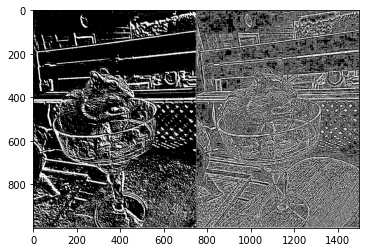

In [84]:
%%time
load_img = cv2.imread("../imgs/img1.jpg") 
load_img = cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB)

plt.imshow(np.column_stack([sobel(load_img),
                            laplace(load_img)]),
           cmap='gray', vmin=0, vmax=255)

### 2) Difuminado de imagen

In [22]:
BLUR3 = np.ones(3) / 3
BLUR15 = np.ones(15) / 15
BLUR30 = np.ones(30) / 30

def difuminate(img, filter_sz=None, blur_weights=None):
    if blur_weights is None:
        blur_weights = np.ones(filter_sz)/filter_sz
    
    img = convolve1d(img, weights=blur_weights, axis=0)
    img = convolve1d(img, weights=blur_weights, axis=1)
    return img

CPU times: user 3.29 s, sys: 18.5 ms, total: 3.31 s
Wall time: 3.3 s


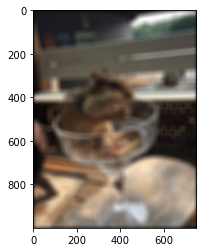

In [12]:
%%time
load_img = cv2.imread("../imgs/img1.jpg")

img = cv2.cvtColor(load_img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
difuminated_img = difuminate(img,30)

plt.imshow(difuminated_img)

### 4) Mejora de nitidez (sharpness)

In [31]:
def sharpness_sobel(img):
    
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    borders = sobel(img, normalize=False)
    
    img_hsv[:,:,2] = img_hsv[:,:,2] - borders
    output = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)

    return output.astype('uint8')

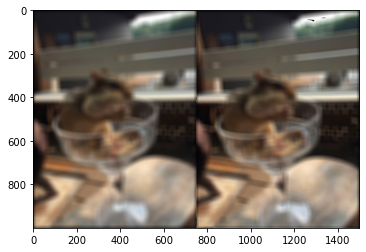

In [14]:
plt.imshow(np.column_stack([difuminated_img,
                            sharpness_sobel(difuminated_img)]))

In [32]:
def sharpness_laplace(img):
    
    #obtiene los bordes de la imagen usando 
    #el kernel de laplace
    borders = laplace(img, normalize=False)
    
    #convierte la imagen a HSV para quedarse con 
    #'value' de la matriz y aumentarle el sharpness
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    img_hsv[:,:,2] = img_hsv[:,:,2] - borders
    
    #convierte de regreso a RGB
    output = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    
    return output.astype('uint8')

CPU times: user 110 ms, sys: 3.94 ms, total: 114 ms
Wall time: 82.1 ms


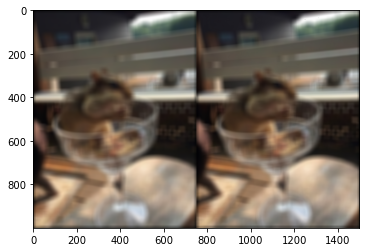

In [16]:
%%time
plt.imshow(np.column_stack([difuminated_img,
                            sharpness_laplace(difuminated_img)]))

In [33]:
def sharpness_mixed(img):
    
    # obtiene los bordes de la imagen con el método 
    # de sobel y de laplace
    borders_laplace = laplace(img, normalize=False)
    borders_sobel = sobel(img, normalize=False)


    
    #convierte la imagen a hsv para modificar
    #el canal de 'value'
    img_hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    #img_hsv[:,:,2] = img_hsv[:,:,2] - ((borders_laplace + borders_sobel)/2)
    img_hsv[:,:,2] = img_hsv[:,:,2] - borders_laplace - borders_sobel
    
    output = cv2.cvtColor(img_hsv, cv2.COLOR_HSV2RGB)
    return output.astype('uint8')

CPU times: user 154 ms, sys: 29 ms, total: 183 ms
Wall time: 112 ms


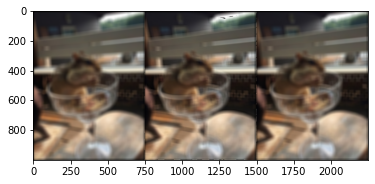

In [18]:
%%time
plt.imshow(np.column_stack([difuminated_img,
                            sharpness_mixed(difuminated_img),
                            sharpness_laplace(difuminated_img)]),
          )

In [35]:
import time

load_img = cv2.imread("../imgs/moon.jpg")
mean_time = 0

for i in range(100):
    
    start = time.time()
    #caso con normalizacion
    sobel(load_img)
    
    end = time.time()
    mean_time += (end - start)/100
    
print("tiempo medio de ejecución de detección de bordes con Sobel: ", mean_time)


tiempo medio de ejecución de detección de bordes con Sobel:  0.1794804239273071


In [36]:
mean_time = 0

for i in range(100):
    
    start = time.time()
    #caso con normalizacion
    laplace(load_img)
    
    end = time.time()
    mean_time += (end - start)/100
    
print("tiempo medio de ejecución detección de bordes con Laplace: ", mean_time)

tiempo medio de ejecución detección de bordes con Laplace:  0.12715580940246582


In [37]:
mean_time = 0

for i in range(100):
    
    start = time.time()
    #caso con normalizacion
    sharpness_sobel(load_img)
    
    end = time.time()
    mean_time += (end - start)/100
    
print("tiempo medio de ejecución mejora de nitidez con Sobel: ", mean_time)

tiempo medio de ejecución mejora de nitidez con Sobel:  0.14181304931640626


In [38]:
mean_time = 0

for i in range(100):
    
    start = time.time()
    #caso con normalizacion
    sharpness_laplace(load_img)
    
    end = time.time()
    mean_time += (end - start)/100
    
print("tiempo medio de ejecución de mejora de nitidez con Laplace: ", mean_time)

tiempo medio de ejecución de mejora de nitidez con Laplace:  0.06479246616363527


In [39]:
mean_time = 0

for i in range(100):
    
    start = time.time()
    #caso con normalizacion
    difuminate(load_img, 30, BLUR30)
    
    end = time.time()
    mean_time += (end - start)/100
    
print("tiempo medio de ejecución de difuminado: ", mean_time)

tiempo medio de ejecución de difuminado:  0.14972011089324955


In [40]:
mean_time = 0

for i in range(100):
    
    start = time.time()
    #caso con normalizacion
    equalize_hsv_channel(load_img)
    
    end = time.time()
    mean_time += (end - start)/100
    
print("tiempo medio de ejecución de ecualización de histogramas: ", mean_time)

tiempo medio de ejecución de ecualización de histogramas:  0.03829743146896362


### Preguntas

1. ¿Cual de los programas implementados corre de forma más lenta y cual de forma más rápida? ¿Porqué?

De los programas implementados, el más lento fué Sobel. Esto es debido, a que en su ejecución debe realizar dos convoluciones, y debe estandarizar su output, para lo cuál necesita calcular la media y la varianza de una matriz $m \times n$. El más rápido fue ecualización de histogramas, ya que funciona a través de un mapeo indexado de variables que no requieren de operaciones muy complejas para ser asignadas.

2. ¿Cómo puedo mejorar la velocidad de los algoritmos de procesamiento? ¿Qué consecuencias tiene esto?

Podemos mejorar la velocidad de los algoritmos de procesamiento hacieno uso de GPUs y paralelizando secciones del código de cada algoritmo. Otra opción, puede ser hacer uso de la transformada discreta de Fourier para imágenes y trabajar con el dominio de frecuencias para transformar la imágen. Esto implica, que podemos procesar imágenes de una resolución alta en muy poco tiempo. También cuando paralelizamos, el código se vuelve mucho más difícil de entender. 

3. Si los programas tienen problemas para realizar las operaciones dentro del tiempo considerado tiempo real, ¿cómo se puede mejorar esto?

Una opción puede ser reescalar el frame de entrada, para que los algoritmos de procesamiento puedan ejecutarse en un tiempo que permita la ejecución en tiempo real. Otra opción puede ser trabajar con valores enteros, esto es debido a que las operaciones con flotantes tienen un mayor tiempo de ejecución.

4. ¿Fueron los resultados obtenidos satisfactorios? Elabore su respuesta.

Los resultados obtenidos fueron satisfactorios. Sin embargo, algunos algoritmos de detección de bordes sobresaturaban o "quemaban" algunas secciones de la imágen haciendo que lo bordes no fuesen delimitados. Algunos algoritmos de mejora de nitidez, cuando recibían una imagen muy difuminada, no podían realzar la calidad lo suficiente como para notar cambios significativos. Finalmente, los algoritmos de ecualización de histogramas y de difuminado funcionaron muy bien, el primero porque realizaba un mapeo que hacía que su tiempo de ejecución fuese muy rápido y el segundo porque realizaba convoluciones para el eje $x$ y el eje $y$ lo cual también disminuyó su tiempo de ejecución.